## Run tests on deconvolution routines

These tests are in a notebook because they take a long time to run, and I'd like to keep the plots around.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pymc3 as pm
from scipy.stats import distributions
import pandas as pd
import os
import matplotlib.pyplot as plt
import datetime
import logging
import sys

sys.path.append(".")
sys.path.append("..")

from rddeconv.forward_model import convolve_radon_timeseries_numpy
from rddeconv.pymc3_deconvolve import fit_model_to_obs
from rddeconv.pymc3_deconvolve import trace_as_xarray
from rddeconv.pymc3_deconvolve import stats_from_xarray
from rddeconv.pymc3_deconvolve import result_plot
import rddeconv

def load_test_data():
    """
    Load data from real observations
    """
    PROJECT_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
    RAW_DATA_DIR = os.path.join(
        PROJECT_DIR, "examples", "goulburn-deconvolution", "raw-data"
    )
    fname_raw_data = os.path.join(
        RAW_DATA_DIR, "Goulburn_Nov_2011_Internal_DB_v01_raw.csv"
    )

    df = rddeconv.load_standard_csv(fname_raw_data)
    # drop problematic first value (lld=1)
    df = df.dropna(subset=["lld"])
    df["lld"].iloc[0] = np.NaN
    df = df.dropna(subset=["lld"])

    # drop the bad data at the end of the record
    df = df.loc[: datetime.datetime(2011, 11, 10, 12)]
    df = df.tail(48)
    counts = df.lld - df.uld
    time = (df.index - df.index[0]).total_seconds()
    time += time[1]
    return time.values, counts.values, df


In [3]:
sp_goulburn = {
    "Q": 0.0122,
    "rs": 0.9,
    "lamp": 0.005555555555555556,
    "eff": 0.14539,
    "Q_external": 0.0006666666666666666,
    "V_delay": 0.2,
    "V_tank": 0.75,
    "expected_change_std": 1.25,
    "total_efficiency": 0.154,
}


### Experiment with differnet smoothing parameters

Less smoothing should result in a reconstructed timeseries with more variability.

In [4]:
#logging.disable(level=logging.INFO)

In [5]:
def run_test(expected_change_std):
    sp = {}
    sp.update(sp_goulburn)
    if expected_change_std is None:
        del(sp['expected_change_std'])
    else:
        sp['expected_change_std'] = expected_change_std


    time_obs, counts_obs, df = load_test_data()
    fit_result = fit_model_to_obs(
        time_obs, counts_obs, detector_params=sp
    )
    trace_obs = fit_result["trace"]
    ds_trace_obs = trace_as_xarray(df.index.values, trace_obs)
    ds_summary_obs = stats_from_xarray(ds_trace_obs)

    fig, ax = result_plot(ds_summary_obs)
    ax.set_title(f'expected_change_std={expected_change_std}')
    return fig, ax
    

[I PID=9259 10:39:13] Running deconvolution
[I PID=9259 10:39:13] Smoothing radon concentration timeseries: True
[W PID=9259 10:39:13] Background count rate not specified, assuming zero
[I PID=9259 10:39:13] Timeseries is 48 points long with 0 NaN values
[D PID=9259 10:39:13] Timestep is 30.0 minutes
[D PID=9259 10:39:13] Radon reference value is 10.16504329004329, radon at t=0 (prior estimate) is 9.527417027417028
[D PID=9259 10:39:37] Applied log-transform to rs and added transformed rs_log__ to model.
[D PID=9259 10:39:37] Applied log-transform to rn0 and added transformed rn0_log__ to model.
[D PID=9259 10:39:37] Applied log-transform to Q_external and added transformed Q_external_log__ to model.
[I PID=9259 10:39:51] Constructing model took 37.9 seconds
[D PID=9259 10:40:12] Test point logp:
    logradon               -0.76
    rs_log__                2.78
    rn0_log__               0.58
    Q_external_log__        2.78
    counts             -24091.14
    Name: Log-probability o

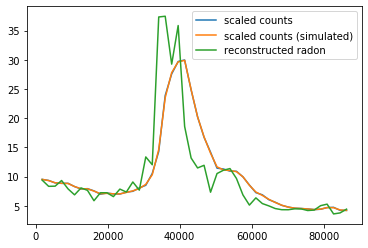

[I PID=9259 10:45:03] MCMC diagnostics took 312.0 seconds
[I PID=9259 10:45:03] Auto-assigning NUTS sampler...
[I PID=9259 10:45:03] Initializing NUTS using jitter+adapt_diag...
[I PID=9259 10:48:51] Multiprocess sampling (4 chains in 4 jobs)
[I PID=9259 10:48:51] NUTS: [Q_external, rn0, rs, logradon]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [06:58<00:00, 14.32draws/s]
[I PID=9259 10:58:49] MCMC sampling 4 chains of 1000 points each took 826.7 seconds


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f977c6dbd50>)

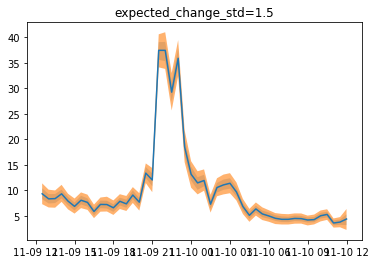

In [6]:
run_test(1.5)

[I PID=9259 10:59:07] Running deconvolution
[I PID=9259 10:59:07] Smoothing radon concentration timeseries: True
[W PID=9259 10:59:07] Background count rate not specified, assuming zero
[I PID=9259 10:59:07] Timeseries is 48 points long with 0 NaN values
[D PID=9259 10:59:07] Timestep is 30.0 minutes
[D PID=9259 10:59:07] Radon reference value is 10.16504329004329, radon at t=0 (prior estimate) is 9.527417027417028
[D PID=9259 10:59:07] Applied log-transform to rs and added transformed rs_log__ to model.
[D PID=9259 10:59:07] Applied log-transform to rn0 and added transformed rn0_log__ to model.
[D PID=9259 10:59:07] Applied log-transform to Q_external and added transformed Q_external_log__ to model.
[I PID=9259 10:59:27] Constructing model took 20.5 seconds
[D PID=9259 10:59:42] Test point logp:
    logradon               27.31
    rs_log__                2.78
    rn0_log__               0.58
    Q_external_log__        2.78
    counts             -24091.14
    Name: Log-probability o

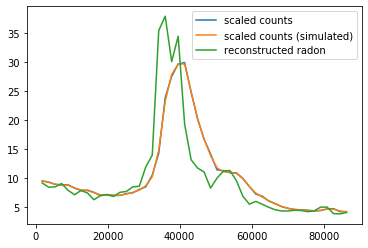

[I PID=9259 11:04:26] MCMC diagnostics took 298.8 seconds
[I PID=9259 11:04:26] Auto-assigning NUTS sampler...
[I PID=9259 11:04:26] Initializing NUTS using jitter+adapt_diag...
[I PID=9259 11:08:11] Multiprocess sampling (4 chains in 4 jobs)
[I PID=9259 11:08:11] NUTS: [Q_external, rn0, rs, logradon]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [04:22<00:00, 22.84draws/s]
[I PID=9259 11:15:20] MCMC sampling 4 chains of 1000 points each took 653.6 seconds


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f97af7cdad0>)

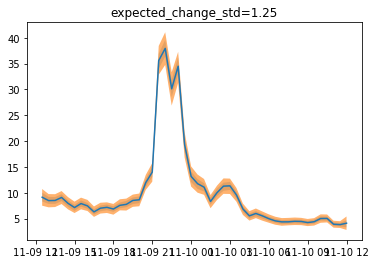

In [7]:
run_test(1.25)

[I PID=9259 11:15:48] Running deconvolution
[I PID=9259 11:15:48] Smoothing radon concentration timeseries: True
[W PID=9259 11:15:48] Background count rate not specified, assuming zero
[I PID=9259 11:15:48] Timeseries is 48 points long with 0 NaN values
[D PID=9259 11:15:48] Timestep is 30.0 minutes
[D PID=9259 11:15:48] Radon reference value is 10.16504329004329, radon at t=0 (prior estimate) is 9.527417027417028
[D PID=9259 11:15:48] Applied log-transform to rs and added transformed rs_log__ to model.
[D PID=9259 11:15:48] Applied log-transform to rn0 and added transformed rn0_log__ to model.
[D PID=9259 11:15:48] Applied log-transform to Q_external and added transformed Q_external_log__ to model.
[I PID=9259 11:15:58] Constructing model took 9.9 seconds
[D PID=9259 11:16:13] Test point logp:
    logradon               98.76
    rs_log__                2.78
    rn0_log__               0.58
    Q_external_log__        2.78
    counts             -24091.14
    Name: Log-probability of

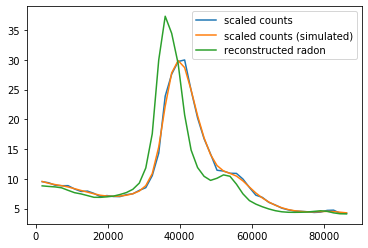

[I PID=9259 11:21:07] MCMC diagnostics took 308.6 seconds
[I PID=9259 11:21:07] Auto-assigning NUTS sampler...
[I PID=9259 11:21:07] Initializing NUTS using jitter+adapt_diag...
[I PID=9259 11:24:54] Multiprocess sampling (4 chains in 4 jobs)
[I PID=9259 11:24:54] NUTS: [Q_external, rn0, rs, logradon]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [02:14<00:00, 44.50draws/s]
[I PID=9259 11:30:10] MCMC sampling 4 chains of 1000 points each took 543.9 seconds


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f97c9443910>)

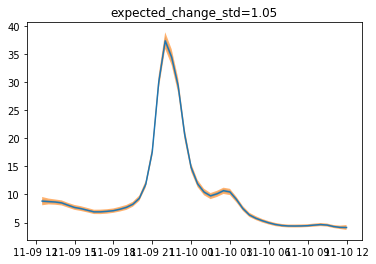

In [8]:
run_test(1.05)

[I PID=9259 11:30:28] Running deconvolution
[I PID=9259 11:30:28] Smoothing radon concentration timeseries: True
[W PID=9259 11:30:28] Background count rate not specified, assuming zero
[I PID=9259 11:30:28] Timeseries is 48 points long with 0 NaN values
[D PID=9259 11:30:28] Timestep is 30.0 minutes
[D PID=9259 11:30:28] Radon reference value is 10.16504329004329, radon at t=0 (prior estimate) is 9.527417027417028
[D PID=9259 11:30:28] Applied log-transform to rs and added transformed rs_log__ to model.
[D PID=9259 11:30:28] Applied log-transform to rn0 and added transformed rn0_log__ to model.
[D PID=9259 11:30:29] Applied log-transform to Q_external and added transformed Q_external_log__ to model.
[I PID=9259 11:30:38] Constructing model took 10.1 seconds
[D PID=9259 11:30:54] Test point logp:
    logradon              173.49
    rs_log__                2.78
    rn0_log__               0.58
    Q_external_log__        2.78
    counts             -24091.14
    Name: Log-probability o

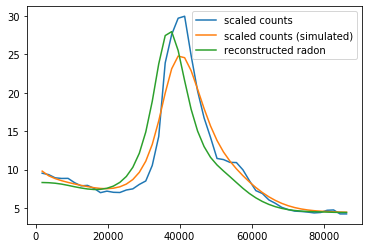

[I PID=9259 11:36:00] MCMC diagnostics took 321.5 seconds
[I PID=9259 11:36:00] Auto-assigning NUTS sampler...
[I PID=9259 11:36:00] Initializing NUTS using jitter+adapt_diag...
[I PID=9259 11:39:58] Multiprocess sampling (4 chains in 4 jobs)
[I PID=9259 11:39:58] NUTS: [Q_external, rn0, rs, logradon]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [05:14<00:00, 19.07draws/s]
[I PID=9259 11:48:25] MCMC sampling 4 chains of 1000 points each took 744.9 seconds


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f977abb19d0>)

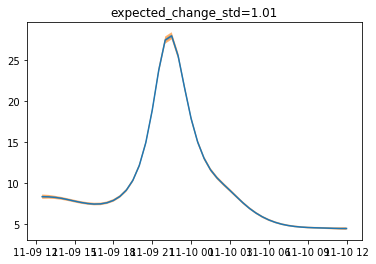

In [9]:
run_test(1.01)

[I PID=9259 11:48:43] Running deconvolution
[I PID=9259 11:48:43] Smoothing radon concentration timeseries: False
[W PID=9259 11:48:43] Background count rate not specified, assuming zero
[I PID=9259 11:48:43] Timeseries is 48 points long with 0 NaN values
[D PID=9259 11:48:43] Timestep is 30.0 minutes
[D PID=9259 11:48:43] Radon reference value is 10.16504329004329, radon at t=0 (prior estimate) is 9.527417027417028
[D PID=9259 11:48:44] Applied log-transform to radon and added transformed radon_log__ to model.
[D PID=9259 11:48:44] Applied log-transform to rs and added transformed rs_log__ to model.
[D PID=9259 11:48:44] Applied log-transform to rn0 and added transformed rn0_log__ to model.
[D PID=9259 11:48:44] Applied log-transform to Q_external and added transformed Q_external_log__ to model.
[I PID=9259 11:48:54] Constructing model took 10.4 seconds
[D PID=9259 11:49:11] Test point logp:
    radon_log__           -26.52
    rs_log__                2.78
    rn0_log__               

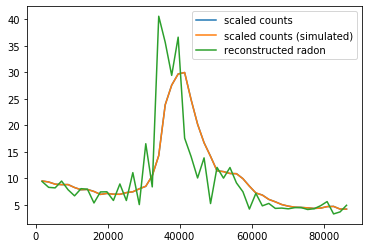

[I PID=9259 11:54:53] MCMC diagnostics took 359.4 seconds
[I PID=9259 11:54:53] Auto-assigning NUTS sampler...
[I PID=9259 11:54:53] Initializing NUTS using jitter+adapt_diag...
[I PID=9259 11:59:04] Multiprocess sampling (4 chains in 4 jobs)
[I PID=9259 11:59:04] NUTS: [Q_external, rn0, rs, radon]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [12:47<00:00,  7.82draws/s] 
[I PID=9259 12:15:09] MCMC sampling 4 chains of 1000 points each took 1216.1 seconds


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f978a84eed0>)

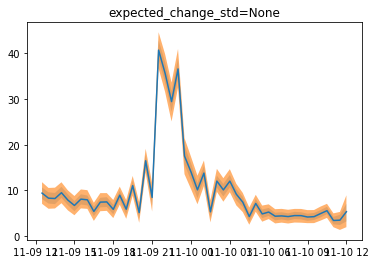

In [10]:
run_test(None)